In [111]:
import os
import cv2
import numpy as np
import json
import pickle
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import shapely
from shapely import geometry

## Reading the OCRed Data 

In [75]:
hdr = {}
for dirpath, subdir ,file_names in os.walk(r"D:\tests\ML_assignment_IDfy\out_dir\hdr"):
    for file_name in file_names:
        if file_name.endswith('.csv'):
            file_path = os.path.join(dirpath, file_name)
            file_key = file_path.replace(r'D:\tests\ML_assignment_IDfy\out_dir\hdr\crop_h', 'crop_')
            if file_key in hdr.keys():
                continue
            try:
                result = pd.read_csv(file_path, dtype={'OCR': 'str'})
                hdr[file_key] = result
            except Exception as e:
                print(e)
                print(file_path)
normal = {}
for dirpath, subdir ,file_names in os.walk(r"D:\tests\ML_assignment_IDfy\out_dir\normal"):
    for file_name in file_names:
        if file_name.endswith('.csv'):
            file_path = os.path.join(dirpath, file_name)
            file_key = file_path.replace(r"D:\tests\ML_assignment_IDfy\out_dir\normal\crop_m", 'crop_')
            if file_key in normal.keys():
                continue
            try:
                result = pd.read_csv(file_path, dtype={'OCR': 'str'})
                normal[file_key] = result
            except Exception as e:
                print(e)
                print(file_path)

In [73]:
len(hdr), len(normal)

(326, 326)

## Train- Test Split

In [92]:
training_keys , test_keys = train_test_split(list(hdr.keys()), test_size = 0.2, random_state = 5)

In [93]:
hdr_test = {key: hdr[key] for key in test_keys}
hdr_training = {key: hdr[key] for key in training_keys}
normal_test = {key: normal[key] for key in test_keys}
normal_training = {key: normal[key] for key in training_keys}

In [95]:
len(hdr_training), len(hdr_test)

(260, 66)

## Feature Creation from the Bounding Boxes

In [121]:
height_ratios_hdr = []
height_ratios_normal = []
area_ratios_hdr = []
area_ratios_normal = []
for key, value in hdr_training.items():
  image_path = key.replace('crop_', r'D:\tests\ML_assignment_IDfy\hdr\crop_h')
  image_path = image_path.replace('\\csvs\\',"\\")
  image_path = image_path.replace('.csv','.png')
  img = cv2.imread(image_path)
  height, width,_ = img.shape
  for _,box in value.iterrows():
    h = max(abs(box['y3'] - box['y1']), abs(box['y4'] - box['y1']))
    height_ratio = h/height
    poly = geometry.Polygon(((box['x1'],box['y1']),(box['x2'],box['y2']),(box['x3'],box['y3']),(box['x4'],box['y4'])))
    height_ratios_hdr.append(height_ratio)
    area_ratios_hdr.append(poly.area/(height*width))
  for _,box in normal_training[key].iterrows():
    h = max(abs(box['y3'] - box['y1']), abs(box['y4'] - box['y1']))
    height_ratio = h/height
    poly = geometry.Polygon(((box['x1'],box['y1']),(box['x2'],box['y2']),(box['x3'],box['y3']),(box['x4'],box['y4'])))
    height_ratios_normal.append(height_ratio)
    area_ratios_normal.append(poly.area/(height * width))

In [153]:
height_ratios_hdr_test = []
height_ratios_normal_test = []
area_ratios_hdr_test = []
area_ratios_normal_test = []
for key, value in hdr_test.items():
  image_path = key.replace('crop_', r'D:\tests\ML_assignment_IDfy\hdr\crop_h')
  image_path = image_path.replace('\\csvs\\',"\\")
  image_path = image_path.replace('.csv','.png')
  img = cv2.imread(image_path)
  height, width,_ = img.shape
  for _,box in value.iterrows():
    h = max(abs(box['y3'] - box['y1']), abs(box['y4'] - box['y1']))
    height_ratio = h/height
    poly = geometry.Polygon(((box['x1'],box['y1']),(box['x2'],box['y2']),(box['x3'],box['y3']),(box['x4'],box['y4'])))
    height_ratios_hdr_test.append(height_ratio)
    area_ratios_hdr_test.append(poly.area/(height*width))
  for _,box in normal_test[key].iterrows():
    h = max(abs(box['y3'] - box['y1']), abs(box['y4'] - box['y1']))
    height_ratio = h/height
    poly = geometry.Polygon(((box['x1'],box['y1']),(box['x2'],box['y2']),(box['x3'],box['y3']),(box['x4'],box['y4'])))
    height_ratios_normal_test.append(height_ratio)
    area_ratios_normal_test.append(poly.area/(height * width))

## Visualization of the Features

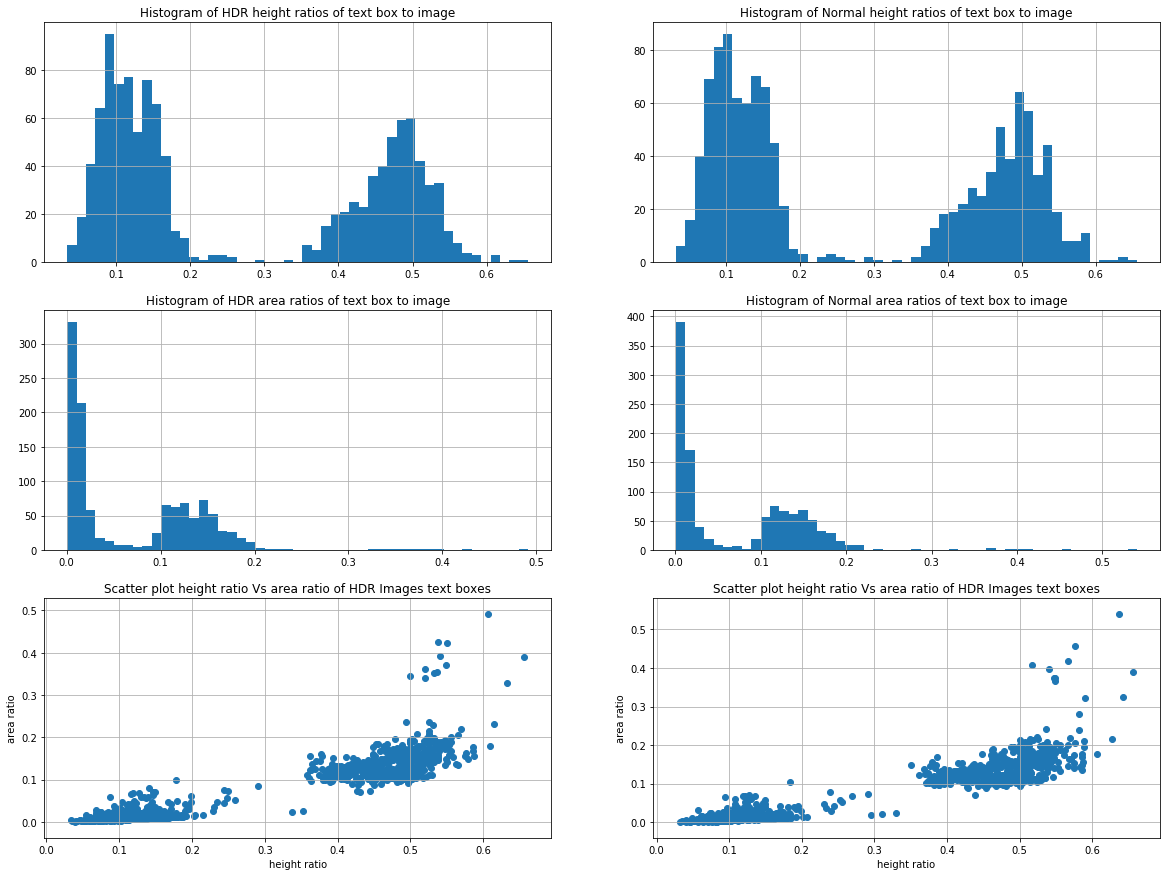

In [128]:
import math
from matplotlib import pyplot as plt

plt.figure(figsize=(20,15))

# linear
plt.subplot(321)
data = np.array(height_ratios_hdr)
bins = np.linspace(min(data), max(data),50) 
plt.hist(data, bins=bins)
plt.title('Histogram of HDR height ratios of text box to image')
plt.grid(True)

plt.subplot(322)
data = np.array(height_ratios_normal)
bins = np.linspace(min(data), max(data),50) 
plt.hist(data, bins=bins)
plt.title('Histogram of Normal height ratios of text box to image')
plt.grid(True)

plt.subplot(323)
data = np.array(area_ratios_hdr)
bins = np.linspace(min(data), max(data),50) 
plt.hist(data, bins=bins)
plt.title('Histogram of HDR area ratios of text box to image')
plt.grid(True)

plt.subplot(324)
data = np.array(area_ratios_normal)
bins = np.linspace(min(data), max(data),50) 
plt.hist(data, bins=bins)
plt.title('Histogram of Normal area ratios of text box to image')
plt.grid(True)


plt.subplot(325)
plt.scatter(height_ratios_hdr, area_ratios_hdr)
plt.title('Scatter plot height ratio Vs area ratio of HDR Images text boxes')
plt.xlabel('height ratio')
plt.ylabel('area ratio')
plt.grid(True)

plt.subplot(326)
plt.scatter(height_ratios_normal, area_ratios_normal)
plt.title('Scatter plot height ratio Vs area ratio of HDR Images text boxes')
plt.xlabel('height ratio')
plt.ylabel('area ratio')
plt.grid(True)


plt.show()

## Clustering using features to differentiate box types

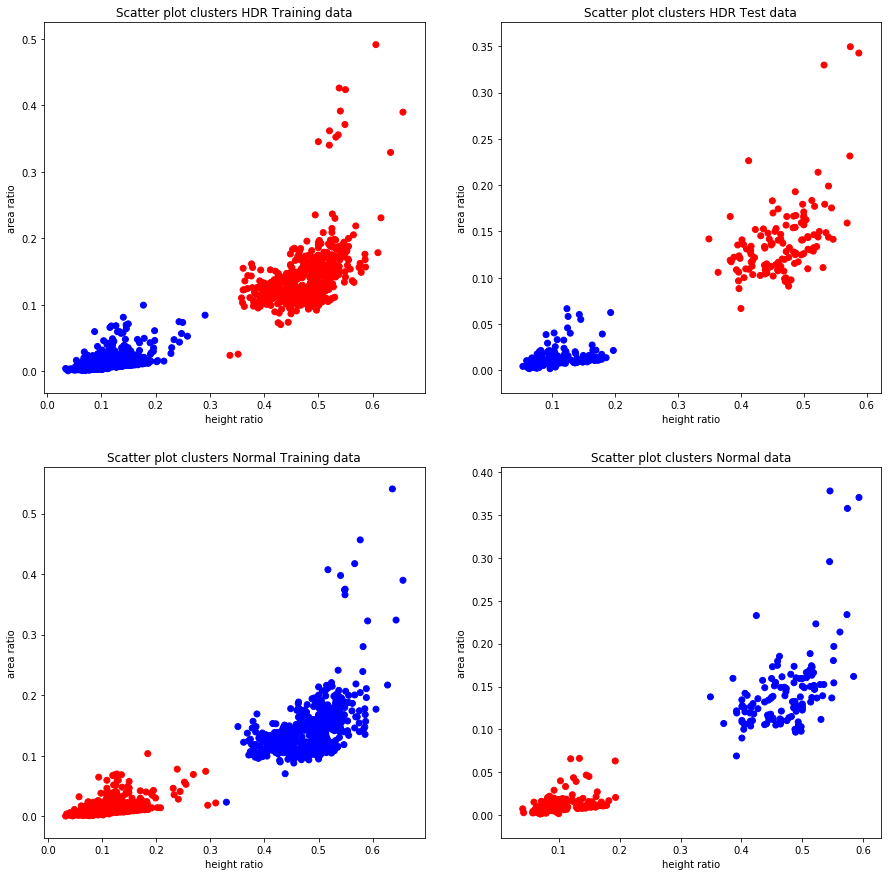

In [155]:
from sklearn import cluster
k_means_normal = cluster.KMeans(n_clusters=2)
X_normal = np.array([height_ratios_normal, area_ratios_normal]).T
k_means_normal.fit(X_normal)
y_pred_normal = k_means_normal.predict(X_normal)
test_normal = np.array([height_ratios_normal_test, area_ratios_normal_test]).T
y_test_normal = k_means_normal.predict(test_normal)

k_means_hdr = cluster.KMeans(n_clusters=2)
X_hdr = np.array([height_ratios_hdr, area_ratios_hdr]).T
k_means_hdr.fit(X)
y_pred_hdr = k_means_hdr.predict(X_hdr)
test_hdr = np.array([height_ratios_hdr_test, area_ratios_hdr_test]).T
y_test_hdr = k_means_hdr.predict(test_hdr)

colors=  np.array(['r','b'])
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.scatter(X_hdr[:, 0], X_hdr[:, 1], color=colors[y_pred_hdr].tolist())
plt.title('Scatter plot clusters HDR Training data')
plt.xlabel('height ratio')
plt.ylabel('area ratio')

plt.subplot(222)
plt.scatter(test_hdr[:, 0], test_hdr[:, 1], color=colors[y_test_hdr].tolist())
plt.title('Scatter plot clusters HDR Test data')
plt.xlabel('height ratio')
plt.ylabel('area ratio')

plt.subplot(223)
plt.scatter(X_normal[:, 0], X_normal[:, 1], color=colors[y_pred_normal].tolist())
plt.title('Scatter plot clusters Normal Training data')
plt.xlabel('height ratio')
plt.ylabel('area ratio')

plt.subplot(224)
plt.scatter(test_normal[:, 0], test_normal[:, 1], color=colors[y_test_normal].tolist())
plt.title('Scatter plot clusters Normal data')
plt.xlabel('height ratio')
plt.ylabel('area ratio')

plt.show()

## Combining Test data based on the results from the clustering above

In [169]:
out_hdr = {}
item_num = 0
for key, value in hdr_test.items():
  boxes = []
  for _,box in value.iterrows():
    if y_test_hdr[item_num] == 0:
      boxes.append((box['x1'], box['OCR'], box['Conf']))
    item_num += 1
    
  boxes.sort(key= lambda item: item[0])
  if boxes:
    text = ""
    conf = 0.0
    for box in boxes:
      text += str(box[1])
      conf += box[2]
    text = re.sub('[^A-Za-z0-9]+', '', text)
    text = text.upper()
    confidence = conf/len(boxes)
    out_hdr[key] = (text, confidence)
  else:
    out_hdr[key] = ("", 0.0)

In [174]:
out_normal = {}
item_num = 0
for key, value in normal_test.items():
  boxes = []
  for _,box in value.iterrows():
    if y_test_normal[item_num] == 1:
      boxes.append((box['x1'], box['OCR'], box['Conf']))
    item_num += 1
    
  boxes.sort(key= lambda item: item[0])
  if boxes:
    text = ""
    conf = 0.0
    for box in boxes:
      text += str(box[1])
      conf += box[2]
    text = re.sub('[^A-Za-z0-9]+', '', text)
    text = text.upper()
    confidence = conf/len(boxes)
    out_normal[key] = (text, confidence)
  else:
    out_normal[key] = ("", 0.0)

In [175]:
out = {}
for key, value in out_normal.items():
  if out_hdr[key][1] > value[1]:
    out[key] = out_hdr[key]
  else:
    out[key] = value

In [176]:
import csv

with open('dataset.csv', mode='r') as infile:
    reader = csv.reader(infile)
    gt_dict = {rows[0]:rows[1] for rows in reader}

## Checking Accuracy and Errors

In [184]:
correct = 0
correct_hdr = 0
correct_normal = 0
print("Image name               Ground truth       HDR output               Normal output")
for key, value in out.items():
  name = key.replace('crop_', 'crop_m')
  name = name.replace('\\csvs\\','/')
  name = name.replace('.csv','.png')
  if gt_dict[name] != value[0]:
    print(f"{key}     {gt_dict[name]}     {out_hdr[key]}      {out_normal[key]}")
  else:
    correct +=1
  if gt_dict[name] == out_hdr[key][0]:
    correct_hdr +=1
  if gt_dict[name] == out_normal[key][0]:
    correct_normal +=1
print(f"correct HDR: {correct_hdr}, accuracy: {correct_hdr/len(out)}")
print(f"correct Normal: {correct_normal}, accuracy: {correct_normal/len(out)}")
print(f"correct Best {correct}, accuracy: {correct/len(out)}")

Image name               Ground truth       HDR output               Normal output
crop_3\csvs\I00010.csv     6M04291     ('6MO4291', 0.9961856)      ('6MO4291', 0.986949675)
crop_4\csvs\I00077.csv     8B68508     ('8868508', 0.99721205)      ('8868508', 0.99672815)
crop_2\csvs\I00042.csv     7B15714     ('7B185714', 0.98860794)      ('7B15714', 0.98435885)
crop_4\csvs\I00042.csv     9B54817     ('', 0.0)      ('', 0.0)
crop_4\csvs\I00061.csv     1BI1710     ('1B11710', 0.9859755)      ('1B11710', 0.9930318300000001)
crop_4\csvs\I00016.csv     3B88729     ('3888729', 0.999255765)      ('3B88729', 0.9970641499999999)
crop_4\csvs\I00027.csv     5M56740     ('5N56740', 0.8004123000000001)      ('5596740', 0.814174)
crop_3\csvs\I00084.csv     1BI2138     ('1B12138', 0.98784133)      ('1B12138', 0.98034985)
crop_3\csvs\I00061.csv     1BA8370     ('1BA98370', 0.99315003)      ('1BA98370', 0.99314827)
correct HDR: 54, accuracy: 0.8181818181818182
correct Normal: 56, accuracy: 0.84848484848484